In [1]:
import cv2 as cv
import numpy as np 
import os 
import matplotlib.pyplot as plt
import imutils
import image_slicer
import tensorflow
from tensorflow.keras.models import load_model
model = load_model('model/model.h5')


In [2]:
class SudokuSolver:
    
    def __init__(self,matrix):
        self.matrix = matrix
        
    #this function find an empty cell, return indices of the cell  
    def find_empty_grid(self,matrix):
        for i in range(len(matrix)):
            for j in range(len(matrix[0])):
                if matrix[i][j] == 0:
                    return (i, j)  #return row, col
        return None
    
    #this function checks the constraints
    def possible(self,matrix, num, pos):
        for i in range(len(matrix[0])):
            if matrix[pos[0]][i] == num and pos[1] != i:
                return False
        for i in range(len(matrix)):
            if matrix[i][pos[1]] == num and pos[0] != i:
                return False
            
        x0 = (pos[1] // 3)*3
        y0 = (pos[0] // 3)*3
        for i in range(y0, y0+ 3):
            for j in range(x0, x0 + 3):
                if matrix[i][j] == num and (i,j) != pos:
                    return False
        return True
    
    def solve_array(self):
        find = self.find_empty_grid(self.matrix) #find the empty spaces
        if not find:
            return True
        else:
            row, col = find

        for i in range(1,10):
            if self.possible(self.matrix, i, (row, col)): #check the constraints
                self.matrix[row][col] = i

                if self.solve_array():
                    return True

                self.matrix[row][col] = 0

        return False
    
    def get_matrix(self):
        return self.matrix

In [3]:
def sud_wrapping(image):
    #image = cv.resize(image,(300,300))
    ratio = image.shape[0]/300.0
    orig = image.copy()
    image = imutils.resize(image , height = 300)
    gray  = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    gray = cv.bilateralFilter(gray,11,17,17)
    edged = cv.Canny(gray,30,200)
    gray  = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    gray = cv.bilateralFilter(gray,11,17,17)
    edged = cv.Canny(gray,30,200)
    
    # find contours in the edged image, keep only the largest
    # ones, and initialize our screen contour
    cnts = cv.findContours(edged.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv.contourArea, reverse = True)[:10]
    screenCnt = None


    for c in cnts:
        peri = cv.arcLength(c,True)
        approx  = cv.approxPolyDP(c,0.015*peri ,True)

        if len(approx) == 4:
            screenCnt = approx 
            break

    pts = screenCnt.reshape(4,2)
    rect = np.zeros((4,2),dtype = "float32")

    s  = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts , axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    rect *= ratio 

    (tl,tr,br,bl) = rect 
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    M = cv.getPerspectiveTransform(rect, dst)
    warp = cv.warpPerspective(orig, M, (maxWidth, maxHeight))
    # reversing colors (more easy for digit recognition later)
    return warp 

In [4]:
def pre_process_image(img):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""
    #resize
    proc = cv.resize(img,(900,900))
    proc = cv.cvtColor(proc, cv.COLOR_BGR2GRAY)
    # Gaussian blur with a kernal size (height, width) of 9.
    
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    
    proc = cv.GaussianBlur(proc.copy(), (9,9), 0) # IMPORTANT 

    # Adaptive threshold 
    proc = cv.adaptiveThreshold(proc, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 5, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv.bitwise_not(proc)
    return proc

In [5]:
#return an array of images of numbers 
def split_to_numbers(image):  
    shape  = image.shape[0]
    GRID = 9
    rg = np.linspace(0,shape,10)[:9].astype('int')
    h = w =  int(shape /GRID ) 
    numbers = []
    for i in rg:
        for j in rg:
            crop = image[i:i+h, j:j+w]
            numbers.append(crop)
            
    return numbers 


In [6]:
#predict single number 
def predict_number(image):
    
    image = image.reshape((100,100,1))
    tab = []
    image = image/255
    tab.append(image)
    tab = np.array(tab)
    h = np.expand_dims(tab,axis=2)
    result = model.predict(tab)
    predicted_class = np.argmax(result[0])
    return predicted_class

In [7]:
#predict array of numbers 
def predict_numbers(number_images):
    final = []
    for i in number_images:
        nb = predict_number(i)
        final.append(nb)
    final = np.array(final).reshape((9,9))
    return final 
        

In [8]:
#return matrix of sudoku 
def get_sudoku_matrix(image):
    try:
        result = sud_wrapping(image)
        result = pre_process_image(result)
        images_numbers = split_to_numbers(result)
        final = predict_numbers(images_numbers)
        return final
    except: return("cannot get matrix from the sudoku")

     
    

## Example Step by Step


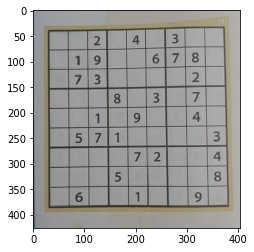

In [9]:
#load image  
image = cv.imread('test_images/sudoku6.jpg')
plt.imshow(image,'gray')


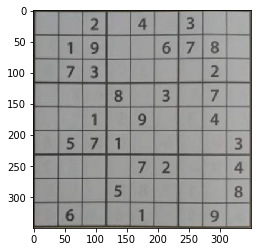

In [10]:
# step 1 : wrapping image 
result = sud_wrapping(image)
plt.imshow(result,'gray')

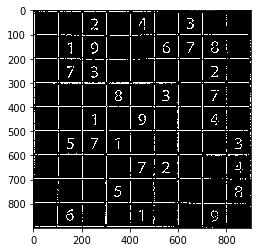

In [11]:
# step 2 : processing image 
result1 = pre_process_image(result)
plt.imshow(result1,'gray')

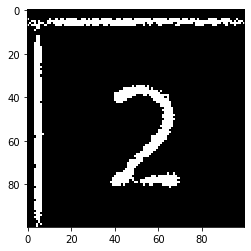

In [12]:
# step 3 : splitting it to an array of images : 
result2 = split_to_numbers(result1)
plt.imshow(result2[2],"gray")

[[0 0 2 0 4 0 3 0 0]
 [0 1 9 0 0 6 7 8 0]
 [0 7 3 0 0 0 0 2 0]
 [0 0 0 8 0 3 0 7 0]
 [0 0 1 0 9 0 0 4 0]
 [0 5 7 1 0 0 0 0 3]
 [0 0 0 0 7 2 0 0 4]
 [0 0 0 5 0 0 0 0 8]
 [0 6 0 0 1 0 0 9 0]]


(None, <matplotlib.image.AxesImage at 0x7f2f60176d90>)

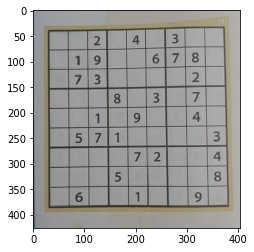

In [13]:
#step4 : predict numbers using the model 
matrix = predict_numbers(result2)
print(matrix) , plt.imshow(image,"gray")

In [50]:
#step 5 : solve the sudoku 
sv = SudokuSolver(matrix)
sv.solve_array()
resolved = sv.get_matrix()
print(resolved)

[[2 5 9 4 8 7 6 1 3]
 [6 3 7 1 5 2 4 9 8]
 [8 4 1 6 9 3 2 7 5]
 [4 6 5 3 1 8 9 2 7]
 [9 1 2 7 4 5 8 3 6]
 [7 8 3 2 6 9 1 5 4]
 [1 7 6 5 2 4 3 8 9]
 [3 2 8 9 7 6 5 4 1]
 [5 9 4 8 3 1 7 6 2]]
